<a href="https://colab.research.google.com/github/spencer18001/Clustering-And-Dimensionality-Reduction---Deep-Dive/blob/main/11/1111.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
!apt install libcairo2-dev pkg-config python3-dev
!pip install igraph leidenalg cairocffi
!wget -O funcs.py https://github.com/spencer18001/Clustering-And-Dimensionality-Reduction---Deep-Dive/blob/main/11/1111_funcs.py?raw=1

## Evaluating communities & utility functions

In [2]:
import copy

import random

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

import igraph as ig

ig.config['plotting.backend']='matplotlib'
plt.rcParams["figure.figsize"] = (10,10)
random.seed(2)

### Load the dataset and find communities

In [3]:
# Load the karakte club dataset
g = ig.Graph.Famous('Zachary')

In [4]:
# Get number of nodes
num_nodes = g.vcount()
num_edges = g.ecount()

g.vs['member_id'] = range(num_nodes)
g.es['weight'] = [1]*num_edges

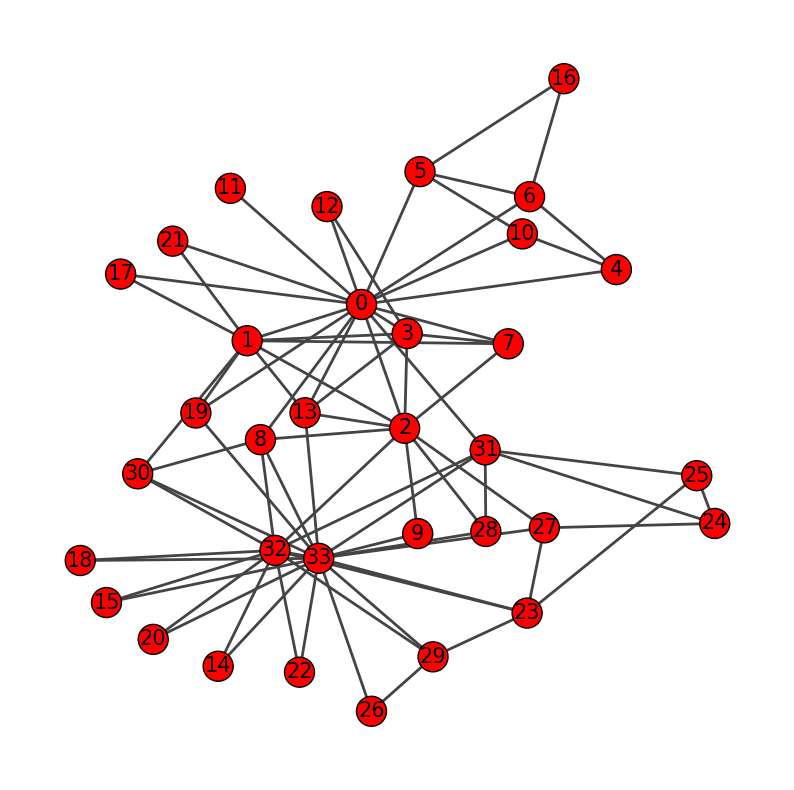

In [6]:
layout = g.layout("auto")
ig.plot(
    g,
    layout=layout,
    vertex_label=g.vs["member_id"],
    vertex_label_size=15
)

In [7]:
ig_clusters = g.community_multilevel(
    resolution=0.4,
    weights='weight'
)

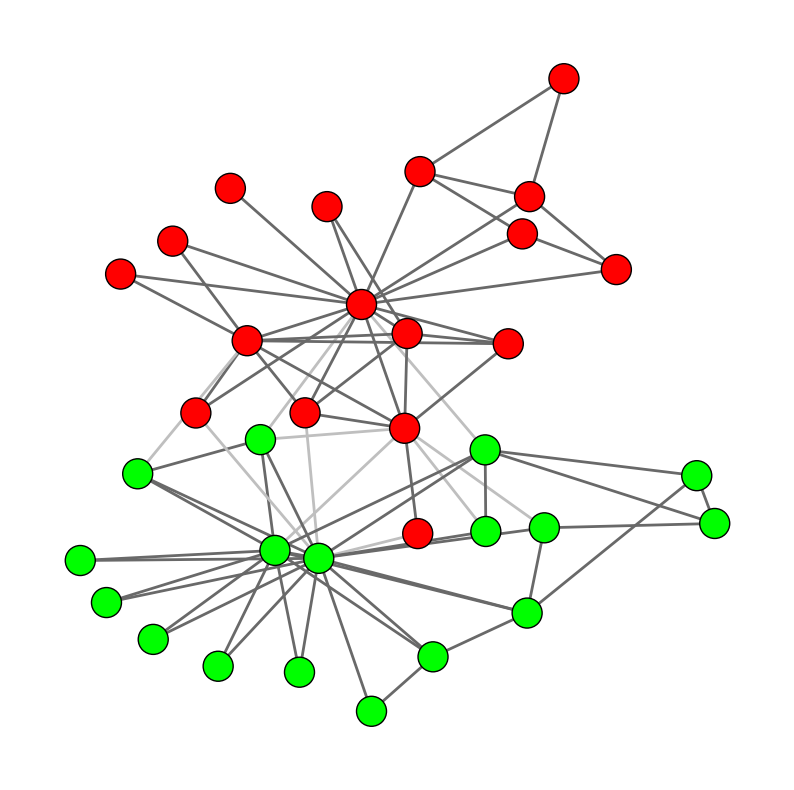

In [8]:
ig.plot(ig_clusters)
# the algorithm has managed to recognize the structure in our data

### Evaluate communities

In [9]:
ig_clusters.modularity
# this is not a good idea if you want to compare this clustering with other clustering
# because this this modularity is for resolution equal 0.4

0.6717948717948719

In [10]:
ig_cluster_ids = ig_clusters.membership

In [11]:
g.modularity(
    membership=ig_clusters.membership,
    directed=False,
    weights='weight'
)
# the better idea is to extract the membership and then use the modularity method of our graph object
# in order to recalculate the modularity for resolution equal 1

0.3717948717948718

In [12]:
def conductance(g_clust):
    """
    This function calculates clustering conductance as
    average of conductance of each cluster. Conductance for each cluster is
    calculated as sum of all edges goind outside cluster divided by minimum
    between volume of cluster and volume of all other nodes.

    :param g_clust: Graph clustering object.
    :return: Clustering conductance.
    """

    # Extract graph object from clustering
    graph = g_clust.graph
    conductance_list = [] # store a per community conductance
    all_node_ids = set(range(graph.vcount()))

    # Calculate conductance for each cluster
    for clust_node_ids in g_clust:
        other_node_ids = list(all_node_ids - set(clust_node_ids))

        external_edges = graph.es.select(_between=(clust_node_ids, other_node_ids))

        conductance_list.append(
            np.sum(external_edges['weight'])/np.min([
                np.sum(graph.strength(clust_node_ids, weights='weight')),
                np.sum(graph.strength(other_node_ids, weights='weight'))
            ])
        )

    return np.mean(conductance_list)

In [13]:
conductance(ig_clusters)
# these communities are not separated so well

0.1282051282051282

In [14]:
def average_internal_node_degree(g_clust):
    """
    Calculates internal node degree.

    :param g_clust: Graph clustering object.
    :return: Average internal node degree.
    """

    # Get graph from igraph clusters
    internal_node_deg = [] # the average internal node degrees of our communities

    # Iterate throug clusters
    for curr_subgraph in g_clust.subgraphs():
        node_degs = np.array(curr_subgraph.strength(weights='weight'))
        internal_node_deg.append(np.mean(node_degs))

    # Return mean value for internal node degree
    return np.mean(internal_node_deg)

In [15]:
average_internal_node_degree(ig_clusters)

4.0

### Utility functions

In [16]:
# min_cluster_size: all the communities having less than minimal cluster size nodes will be considered as noise,
def print_clustering_stats(ig_clusters, min_cluster_size=0):
    """
    Prints number of nodes across clusters.

    :param ig_clusters: Graph clustering object.
    :param min_cluster_size: Adds minimum cluster size
    to prevent too many prints in case big number of
    noise clusters is present.
    """

    # Noise clusters are ones containing less fewer
    # than min_cluster_size nodes
    num_noise_clusters = 0
    num_regular_clusters = 0

    # Noise nodes are nodes belonging to noise
    # clusters
    num_noise_nodes = 0

    # If cluster is not noise cluster then print cluster size
    # For noise clusters only print total number of
    # data points and total number of nodes
    for clust_id, cluster_nodes in enumerate(ig_clusters):
        if len(cluster_nodes)> min_cluster_size:
            print('Cluster {} size : {}'.format(clust_id, len(cluster_nodes)))
            num_regular_clusters += 1
        else:
            num_noise_clusters+=1
            num_noise_nodes += len(cluster_nodes)

    # Print stats
    print('Num regular clusters {}'.format(num_regular_clusters))
    print('Num noise clusters {}'.format(num_noise_clusters))
    print('Num noise cluster nodes {}'.format(num_noise_nodes))

In [17]:
print_clustering_stats(ig_clusters)

Cluster 0 size : 17
Cluster 1 size : 17
Num regular clusters 2
Num noise clusters 0
Num noise cluster nodes 0


In [18]:
# edge_width, vertex_size: which should be set based on the cluster size
def display_network_clusters_labels(g_clust, layout, edge_width=None, vertex_size=None, min_size=0, color_edges=True, title=None, ax=None):
    """
    Plots clustering with legend. Nodes and internal edges of each community will be colored with same color.

    :param g_clust: Cluster graph object.
    :param layout: Graph layout.
    :param edge_width: Edge width, defaults to None.
    :param vertex_size: Vertex size, defaults to None.
    :param min_size: Clusters bellow this size will be considered noise clusters.
    :param color_edges: Whether to color edges in the graph, defaults to True.
    :param title: Graph title, defaults to None.
    :param ax: Matplotlib ax, defaults to None.

    :return: The graph object.
    """

    plt.rcParams["figure.figsize"] = (10,10)

    # Initialize storage for regular clusters and noise clusters
    # Noise clusters are clusters smaller than min_size
    noise_cluster = []
    regular_clusters = []

    noise_cluster_names = []
    regular_cluster_names = []

    # Make deep copy of the graph in
    # order not to mess up the original
    # object
    g_clust = copy.deepcopy(g_clust)
    graph = g_clust.graph

    # Iterate through all the clusters and detect
    # noise clusters
    for clust_id, cluster_nodes in enumerate(g_clust):
        if len(cluster_nodes) > min_size:
            regular_clusters.append(cluster_nodes)
            regular_cluster_names.append(str(clust_id))
        else:
            noise_cluster += cluster_nodes
            noise_cluster_names.append(clust_id)


    # Get number of unique clusters
    num_clusters = len(regular_clusters)

    # Create collor pallete
    collor_palette = ig.ClusterColoringPalette(n=num_clusters)

    # Create legend
    custom_lines = []

    # Iterate through all communities

    # For each community, color internal edges and nodes
    # with same color
    for clust_id, cluster_nodes in enumerate(regular_clusters):
        # Cluster nodes is a list of all node ids
        # bellonging to the current community

        # Add node colors
        graph.vs[cluster_nodes]["color"] = [collor_palette[clust_id]]*len(cluster_nodes)

        # Add edge colors
        if color_edges:
            cluster_edges = graph.es.select(_within=cluster_nodes)
            cluster_edges['color'] = [collor_palette[clust_id]]*len(cluster_edges)

        # Create line object for legend
        custom_lines.append(
            Line2D([0], [0], color=collor_palette[clust_id], lw=4)
        )

    # Handle noise cluster
    if len(noise_cluster) > 0:
        clust_id += 1

        graph.vs[noise_cluster]["color"] = [(0,0,0,0.2)]*len(noise_cluster)
        custom_lines.append(
            Line2D([0], [0], color=[0,0,0,1], lw=4)
        )
        legend_clust_names = regular_cluster_names + ['Outlier cluster']
    else:
        legend_clust_names = regular_cluster_names

    # Determine if matplotlib ax is provided
    if ax is None:
        _, ax = plt.subplots(figsize=(10, 10))

    # Draw network on the figure
    ig.plot(
        graph,
        edge_width=edge_width,
        vertex_size=vertex_size,
        layout=layout,
        target=ax
    )

    # add legend
    ax.legend(custom_lines, legend_clust_names)

    # add title
    if title:
        plt.title(title)

    return g_clust

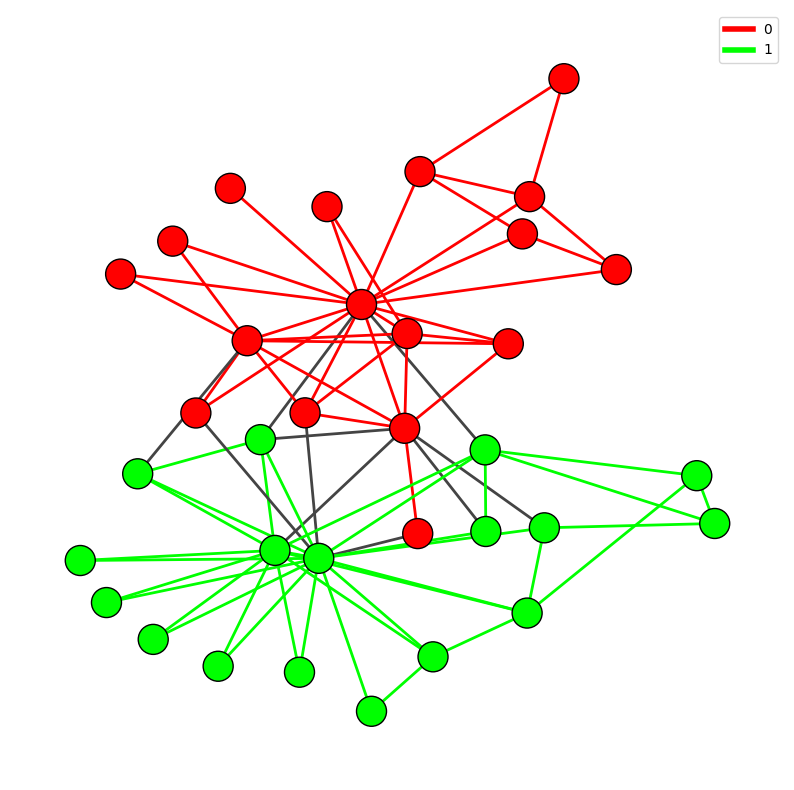

In [19]:
display_network_clusters_labels(
    g_clust=ig_clusters,
    layout=layout
)